In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Section 1: Data Generation

The goal of this section is to create a dataset with categorical features and a continuous target variable.

First, we create a normal dataset with some preset colinearity, including a target variable. These will simply be used as a base for the categorical variables

In [2]:
corr=.7 # Correlation of target variable to the feature bases
multicol= .4 #Correlation of the feature bases to each other
size = 10000 # number of samples

mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=[[1., corr, corr, corr, corr], 
                                                           [corr, 1., multicol, multicol, multicol],
                                                           [corr, multicol, 1., multicol, multicol],
                                                           [corr, multicol, multicol, 1., multicol],
                                                           [corr, multicol, multicol, multicol, 1.]])
raw = mvnorm.rvs(size)

In [3]:
#Add to a dataframe and confirm that the correlations are close
#to our inputs:
normdf = pd.DataFrame(raw)
normdf.columns = ['target', 'norm1', 'norm2', 'norm3', 'norm4']
print(normdf.shape)
normdf.corr()

(10000, 5)


,target,norm1,norm2,norm3,norm4
target,1.000000,0.698962,0.700004,0.702916,0.707610
norm1,0.698962,1.000000,0.398647,0.405262,0.406070
norm2,0.700004,0.398647,1.000000,0.400004,0.409454
norm3,0.702916,0.405262,0.400004,1.000000,0.401909
norm4,0.707610,0.406070,0.409454,0.401909,1.000000


Next, we create some discrete distributions that will represent our categories. By creating different uniform/normalc ombinations as seen below, we ensure that we'll have categories occuring at different frequencies in the dataset.

In [4]:
#Create some categorical features from the feature bases, and sort them 
#The need for sorting will become apparent in a moment
cat1 = np.sort([np.round(x,0) for x in np.random.uniform(high=10.5, low=.5, size=size)])
cat2 = np.sort([np.round(x,0) for x in np.random.uniform(high=5.5, low=.5, size=size)])
cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

In [5]:
# #Create some categorical features from the feature bases, and sort them 
# #The need for sorting will become apparent in a moment
# cat1 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat2 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=.5,size=size)])
# cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

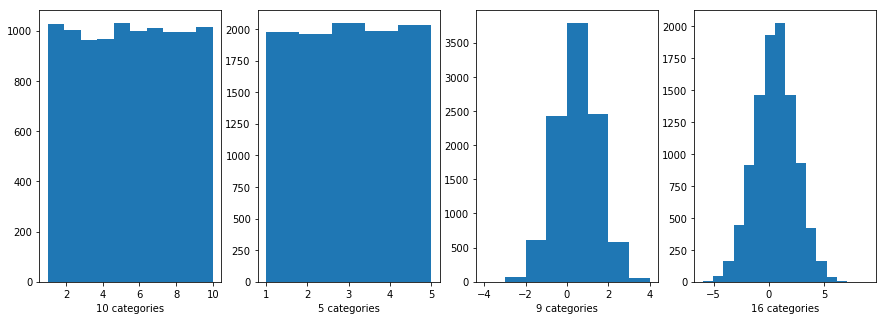

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(141)
plt.hist(cat1, bins=10)
plt.xlabel(str(len(set(cat1)))+" categories")
plt.subplot(142)
plt.hist(cat2, bins=5)
plt.xlabel(str(len(set(cat2)))+" categories")
plt.subplot(143)
plt.hist(cat3, bins=8)
plt.xlabel(str(len(set(cat3)))+" categories")
plt.subplot(144)
plt.hist(cat4, bins=len(set(cat4)))
plt.xlabel(str(len(set(cat4)))+" categories")
plt.show()

By sorting the categories in the same order as the as the normal distributions generated with the multivariate function, we ensure that the categorical features will have a correlation with the target variable.

In [7]:
sortorder1 = stats.rankdata(normdf.norm1, method='ordinal')
sortorder2 = stats.rankdata(normdf.norm2, method='ordinal')
sortorder3 = stats.rankdata(normdf.norm3, method='ordinal')
sortorder4 = stats.rankdata(normdf.norm4, method='ordinal')

In [8]:
generic = pd.DataFrame({
    'target': normdf['target'],
    'feat1' : [int(cat1[i-1]) for i in sortorder1],
    'feat2' : [int(cat2[i-1]) for i in sortorder2],
    'feat3' : [int(cat3[i-1]) for i in sortorder3],
    'feat4' : [int(cat4[i-1]) for i in sortorder4]
})

### Result:
As seen below, the result of the above is a dataframe with 5 categorical variables that have strong correlations with a target variable, and moderate correlations with each other. We will convert the integers to text to obscure these relationships as a way ot simulating a real-life categorical situation.

In [9]:
generic.head()

,target,feat1,feat2,feat3,feat4
0,0.348918,1,5,1,3
1,1.927472,8,5,2,4
2,1.137759,8,4,1,2
3,-1.012644,5,1,0,-1
4,-0.029986,1,3,-1,0


In [10]:
generic.corr()

,target,feat1,feat2,feat3,feat4
target,1.000000,0.677606,0.660123,0.678858,0.699598
feat1,0.677606,1.000000,0.369514,0.381066,0.390384
feat2,0.660123,0.369514,1.000000,0.372682,0.380738
feat3,0.678858,0.381066,0.372682,1.000000,0.386413
feat4,0.699598,0.390384,0.380738,0.386413,1.000000


In [11]:
#confirming the size of the categories we need to fake:
for col in generic.columns[1:]:
    print(col, set(generic[col]))
    print(len(set(generic[col])), "to create")

feat1 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
10 to create
feat2 {1, 2, 3, 4, 5}
5 to create
feat3 {0, 1, 2, 3, 4, -1, -4, -3, -2}
9 to create
feat4 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -2, -6, -5, -4, -3, -1}
16 to create


In [12]:
bestmove = ['three', 'layup', 'dunk', 'pass_oop', 'steal',
            'take_charge','midrange','pass_bounce','post_up','free_throw']
position = ['PG', 'SG', 'SF', 'PF', 'C']
sponsors = ['Nike','Reebok','Puma','Adidas','Air_Jordan','Fila','Under_Armour','AND1']
team = ['Knicks','Lakers','Bulls','Thunder','Heat','Clippers','Nets',
        'Rockets','Raptors','Hawks','Warriors','Blazers','Magic','Suns',
        'Celtics','Bobcats','76ers','Kings','Jazz','Spurs', 'Pistons', 'Bucks']
headband = ['Always','Sometimes','Never']
movie = ['Inception','The_Prestige', 'The Matrix','The_Avengers',
        'Pulp_Fiction','The_GodFather', 'Annihilation','Jaws']

In [13]:
df = pd.DataFrame({
    'all_star_votes': [int(x*10000+1e5) for x in generic['target']],
    'best_move': [bestmove[i-1] for i in generic['feat1']],
    'position': [position[i-1] for i in generic['feat2']],
    'shoe_sponsor': [sponsors[i-1] for i in generic['feat3']],
    'team': [team[i-1] for i in generic['feat4']],
    'wears_headband': [np.random.choice(headband) for _ in range(size)],
    'favorite_movie': [np.random.choice(movie) for _ in range(size)],
})
df.head()

,all_star_votes,best_move,position,shoe_sponsor,team,wears_headband,favorite_movie
0,103489,three,C,Nike,Bulls,Sometimes,Pulp_Fiction
1,119274,pass_bounce,C,Reebok,Thunder,Sometimes,Annihilation
2,111377,pass_bounce,PF,Nike,Lakers,Sometimes,The_Prestige
3,89873,steal,PG,AND1,Pistons,Sometimes,Jaws
4,99700,three,SF,Under_Armour,Bucks,Never,The_GodFather


# Section 2: PCA vs MCA for dimensionality Reduction with Categorical Variables

### One-hot encoded: Regression Baseline

In [14]:
y = df.all_star_votes
Xcat = df.drop('all_star_votes', axis=1)
X = pd.get_dummies(Xcat, drop_first=True)
print(X.shape)
X.head()

(10000, 44)


,best_move_free_throw,best_move_layup,best_move_midrange,best_move_pass_bounce,best_move_pass_oop,best_move_post_up,best_move_steal,best_move_take_charge,best_move_three,position_PF,...,team_Thunder,wears_headband_Never,wears_headband_Sometimes,favorite_movie_Inception,favorite_movie_Jaws,favorite_movie_Pulp_Fiction,favorite_movie_The Matrix,favorite_movie_The_Avengers,favorite_movie_The_GodFather,favorite_movie_The_Prestige
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [16]:
regr = LinearRegression()
regr.fit(X_train, y_train)

print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.8665981335839669
0.8671703716878547


In [17]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8660006347956604

In [18]:
coefs = lasso.coef_
for i, col in enumerate(X.columns):
    print(col, ":", coefs[i])

best_move_free_throw : 8034.119643237591
best_move_layup : -1142.0849412762864
best_move_midrange : 3538.941188323846
best_move_pass_bounce : 4493.983469349943
best_move_pass_oop : 827.8824998117503
best_move_post_up : 5281.516186748597
best_move_steal : 2014.6910489609425
best_move_take_charge : 2432.83223809471
best_move_three : -3833.9536445811955
position_PF : -2867.2670129950657
position_PG : -8870.265226822792
position_SF : -4641.431312254359
position_SG : -6281.475657913304
shoe_sponsor_Adidas : -0.0
shoe_sponsor_Air_Jordan : -10178.799866692083
shoe_sponsor_Fila : -6016.236960890539
shoe_sponsor_Nike : 2961.503022701443
shoe_sponsor_Puma : 9966.751492264508
shoe_sponsor_Reebok : 6204.2334011062
shoe_sponsor_Under_Armour : -2951.6313453935322
team_Bobcats : -4835.719430488102
team_Bucks : 5086.014021084589
team_Bulls : 10108.344460507062
team_Clippers : 15458.956620655166
team_Heat : 13911.364165686284
team_Jazz : -0.0
team_Kings : -1089.9713809884709
team_Knicks : 6824.32596976

## Analysis: 
This model has way too many parameters, and is therefore horrifically overfitting to the point of being useless. 
We need some way to reduce the dimensions.

### PCA

In [19]:
pca = PCA(n_components=10)

In [20]:
scaledX = StandardScaler().fit_transform(X)
pca_components = pca.fit_transform(scaledX)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
print([round(x,2) for x in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
0.3084923109846562


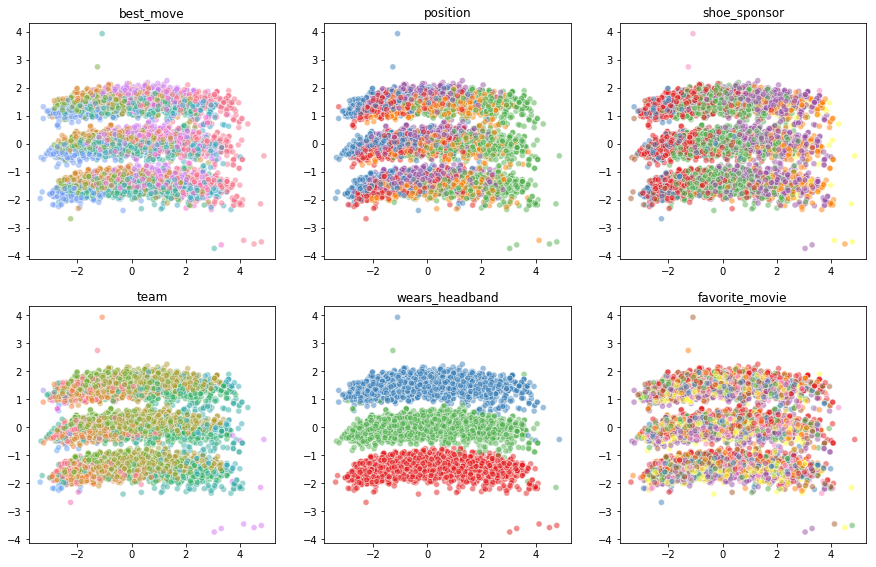

In [22]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

# MCA

In [23]:
mca = prince.MCA(n_components=10)
mca.fit(Xcat)

MCA(check_input=True, copy=True, engine='auto', n_components=10, n_iter=10,
  random_state=None)

In [24]:
mca.total_inertia_

7.333333333333333

In [25]:
print([round(x,2) for x in mca.explained_inertia_])
print(np.sum(mca.explained_inertia_))

[0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
0.2761973002257587


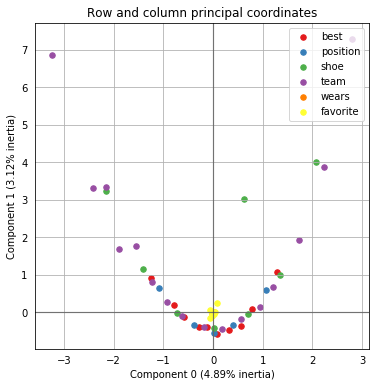

In [26]:
ac = mca.plot_coordinates(X=Xcat,
     ax=None,
     figsize=(6, 6),
     show_row_points=False,
     row_points_size=1,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1)

In [27]:
mca_components = mca.transform(Xcat)
mca_components.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.373612,0.782747,0.292653,0.237638,0.295287,-0.168561,0.029238,0.087301,0.682965,-0.089792
1,-1.196360,0.835780,-0.380864,0.287341,1.000973,0.753459,-0.499450,0.037707,0.473209,-0.279858
2,-0.645799,-0.213502,0.319982,0.644022,0.065511,-0.134741,0.042542,-0.516917,0.073449,-0.019801
3,0.494679,-0.188997,-0.031914,-0.221439,0.002915,0.029787,0.188115,-0.683414,-0.389987,-0.618550
4,0.618243,0.000446,0.102313,0.086588,0.266898,0.170776,-0.078311,0.404635,-0.672246,-0.114287


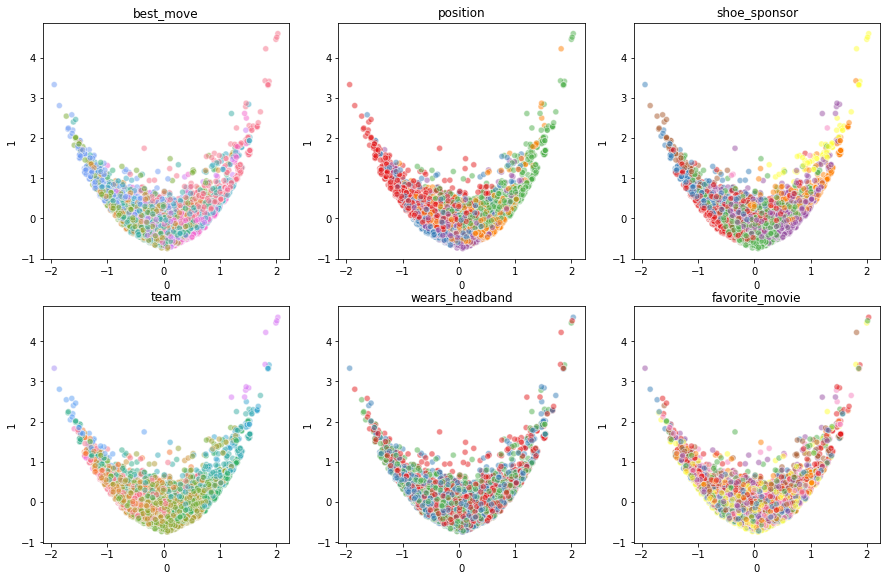

In [28]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=mca_components[0], y=mca_components[1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

Guttman Effect: First dimension has found a linear relationship, and the second is separating high and low outliers from the rest of the items.

# Comparing them both with a simple regression

In [29]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    pca_components, y, test_size=0.33)

mca_X_train, mca_X_test, mca_y_train, mca_y_test = train_test_split(
    mca_components, y, test_size=0.33)

In [30]:
#PCA:
regr.fit(pca_X_train, pca_y_train)
print(regr.score(pca_X_train, pca_y_train))
print(regr.score(pca_X_test, pca_y_test))

0.805182980542648
0.7985818970712519


In [31]:
#MCA:
regr.fit(mca_X_train, mca_y_train)
print(regr.score(mca_X_train, mca_y_train))
print(regr.score(mca_X_test, mca_y_test))

0.8626004670383084
0.8682579066458707


In [33]:
stats.f_oneway(X['best_move_three'],mca_components[0])

F_onewayResult(statistic=234.14841090902473, pvalue=1.4742009925525832e-52)

In [34]:
def anova_viz(comp1, comp2, hotdf):
    results = []
    for cat in hotdf.columns:
        f1, p1 = stats.f_oneway(hotdf[cat], comp1)
        f2, p2 = stats.f_oneway(hotdf[cat], comp2)
        results.append((cat, p1, p2))
    rdf = pd.DataFrame(results, columns=['label','dim1','dim2'])
    plt.figure(figsize=[10,10])
    fig = sns.scatterplot(x='dim1', y='dim2', hue='label',
                          data=rdf, legend=False, s=200)
    for point in range(0,rdf.shape[0]):
        fig.text(rdf.dim1[point]+0.01, rdf.dim2[point], 
        rdf.label[point], horizontalalignment='left', 
            size='medium', color='grey', weight='semibold')
    plt.show()
    return rdf

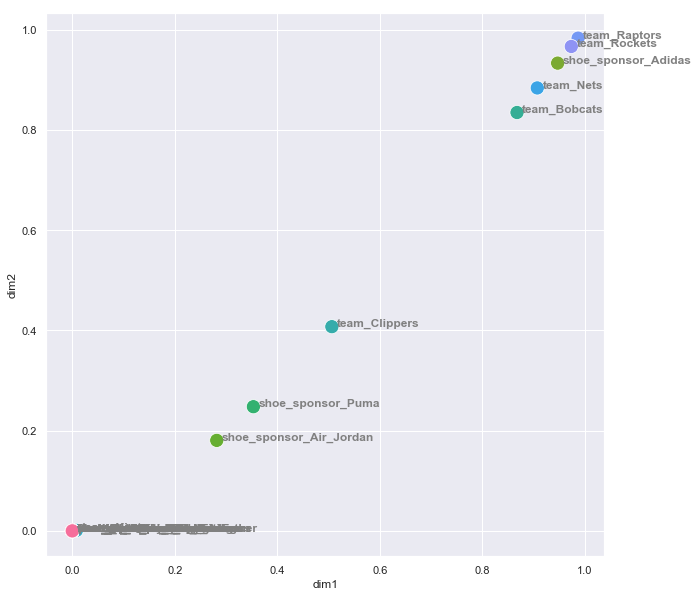

In [35]:
sns.set()
mca_anova = anova_viz(mca_components[0], mca_components[1], X)

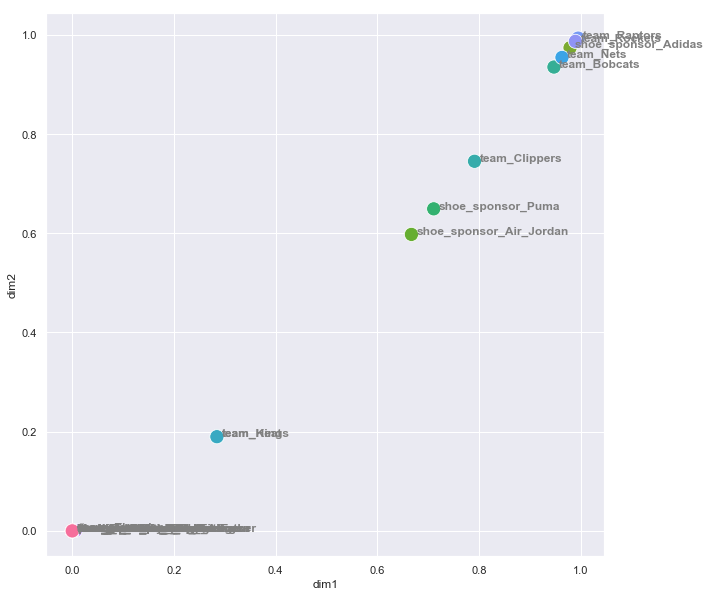

In [36]:
pca_anova = anova_viz(pca_components[:,0], pca_components[:,1], X)

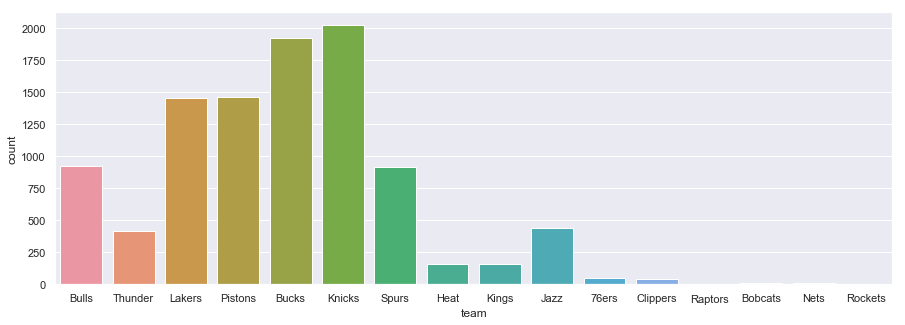

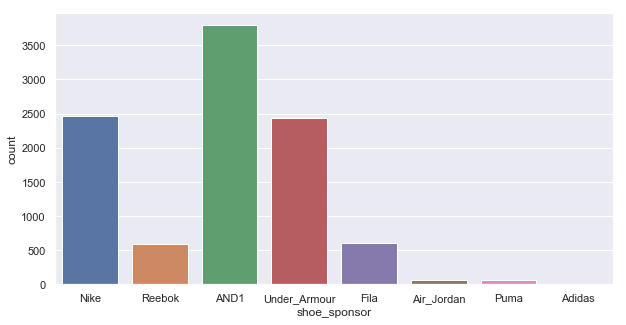

In [37]:
plt.figure(figsize=[15,5])
sns.countplot(df.team)
plt.show()
plt.figure(figsize=[10,5])
sns.countplot(df.shoe_sponsor)
plt.show()